In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
sys.path.append('..')
import linear_regression
from linear_regression.data_preprocess import DataPreprocess
from linear_regression.result_analysis import *

In [3]:
class Args:
    def __init__(self, *,
            data_path,
            train_dates,
            test_dates,
            predict_months          = 3,
            predict_month           = 1,
            predict_mode            = 'predict_changerate_price',
            change_threshold_train  = -1e-9,
            change_threshold_test   = -1e-9,
            classifier_cut_points   = None,
            stocks_only             = '',
            stocks_number           = 10,
            debug                   = False,
            ):

        self.data_path = data_path
        self.train_dates = train_dates
        self.test_dates  = test_dates
        self.predict_months = predict_months
        self.predict_month  = predict_month
        self.predict_mode   = predict_mode
        self.change_threshold_train = change_threshold_train
        self.change_threshold_test  = change_threshold_test
        self.classifier_cut_points  = list(sorted(classifier_cut_points)) if classifier_cut_points is not None else None

        self.stocks_only   = stocks_only
        self.stocks_number = stocks_number

        self.debug = debug

        self.all_indicators = self.get_all_indicators(self.data_path, self.train_dates)

    @property
    def month_label(self):
        return f'{self.predict_month}_{self.predict_mode}'

    @staticmethod
    def get_all_indicators(data_path, train_dates):
        indicators = set()
        for date in train_dates:
            pickle_name = os.path.join(data_path, f'indicators.{date}.pickle')
            df_indicator = pd.read_pickle(pickle_name)
            indicators |= set(df_indicator.columns.tolist())
        indicators.remove('id')
        return list(sorted(indicators))

class DataSet:
    def __init__(self, *,
            x_test,
            y_test,
            y_test_cls,
            id_test,
            x_train,
            y_train,
            y_train_cls,
            id_train):

        self.x_test      = x_test
        self.y_test      = y_test
        self.y_test_cls  = y_test_cls
        self.id_test     = id_test
        self.x_train     = x_train
        self.y_train     = y_train
        self.y_train_cls = y_train_cls
        self.id_train    = id_train

    def get_melted(self):
        x_train_with_id = pd.merge(self.id_train, self.x_train, left_index=True, right_index=True)
        x_train_melted  = pd.melt(x_train_with_id, id_vars=['id'])
        x_test_with_id  = pd.merge(self.id_test, self.x_test, left_index=True, right_index=True)
        x_test_melted   = pd.melt(x_test_with_id, id_vars=['id'])

        return x_train_melted, x_test_melted

In [4]:

def values_to_labels(values, snap_points):
    result = np.ones(values.shape, dtype=int) * -1
    offset = np.ones(values.shape) * np.inf
    for index, point in enumerate(snap_points):
        offset_ = np.abs(values - point)
        result[offset_ < offset] = index
        offset = np.minimum(offset_, offset)

    return result

def preprocess_data(args : Args):
    x_train_, x_test_, y_train_, y_test_, train_id_, test_id_ = DataPreprocess(
        data_path       = args.data_path,
        train_date_list = args.train_dates,
        test_date_list  = args.test_dates,
        n_month_predict = args.predict_months,
        i_month_label   = args.month_label,
        indicator_list  = args.all_indicators).run()

    valid_train, y_train, x_train, stocks_id_train = drop_small_change_stock_fntrain(
        y_train_[args.month_label], x_train_, args.change_threshold_train, train_id_['id'])

    y_test  = y_test_[args.month_label]
    x_test  = x_test_

    if args.classifier_cut_points is not None:
        y_test_cls  = pd.Series(values_to_labels(y_test,  args.classifier_cut_points))
        y_train_cls = pd.Series(values_to_labels(y_train, args.classifier_cut_points))
    else:
        y_test_cls  = None
        y_train_cls = None

    # df = pd.DataFrame(y_test)
    # df['cls'] = y_test_cls
    # df['cls_values'] = np.array([args.classifier_cut_points[x] for x in y_test_cls])
    # print(df)

    if args.debug:
        print('train pre-drop:  ', x_train_.shape, y_train_.shape)
        print('train post-drop: ', x_train.shape,  y_train.shape)
        print('test:            ', x_test.shape,   y_test.shape)

    return DataSet(
        y_test_cls  = y_test_cls,
        y_test      = y_test,
        x_test      = x_test,
        id_test     = test_id_,
        y_train_cls = y_train_cls,
        y_train     = y_train,
        x_train     = x_train,
        id_train    = stocks_id_train,
    )

In [5]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 12)})
sns.set_theme(style="whitegrid")

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [6]:
k_data_path = '../generate_data/regress_data/past_4_quarters/'
k_train_dates = [
    #'2020-06-30',
    '2020-09-30',
    '2020-12-31',
    '2021-03-31',
    '2021-06-30',
    #'2021-09-30',
]

#k_test_dates = ['2021-06-30']
k_test_dates = ['2021-09-30']
#k_test_dates = ['2021-12-31']

k_predict_mode  = 'predict_changerate_price'

k_change_threshold_train = -1e-9
k_change_threshold_test  = -1e-9

k_cutpoints = [-0.3, -0.1, 0.1, 0.3]
#k_cutpoints = [-0.2, -0.1, 0.1, 0.2]
#k_cutpoints = [-0.3, -0.2, 0.2, 0.3]
k_stocks_only = '.SH'

In [7]:
args = Args(data_path   = k_data_path,
            train_dates = k_train_dates,
            test_dates  = k_test_dates,
            predict_mode= k_predict_mode,
            classifier_cut_points = k_cutpoints,
            change_threshold_test  = k_change_threshold_test,
            change_threshold_train = k_change_threshold_train,
            stocks_only = k_stocks_only
            )

In [8]:
import sklearn
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.mixture import *
from sklearn.svm import *
from sklearn.neural_network import *
from sklearn.neighbors import *

from sklearn.metrics import *

import xgboost as xgb

def compute_feature_importance(dataset : DataSet, args : Args):
    model = RandomForestRegressor(max_depth=None, random_state=0)
    model.fit(dataset.x_train, dataset.y_train)
    model.score(dataset.x_test, dataset.y_test)

    importance = pd.DataFrame(zip(args.all_indicators, model.feature_importances_))
    importance.columns = ['indicator', 'importance']

    return importance.sort_values('importance')

def compute_classifier_gain(dataset : DataSet, args : Args):
    estimators=[
        ('rf1', RandomForestClassifier(max_depth=None, n_estimators=100, random_state=0)),
        #('rf2', RandomForestClassifier(max_depth=None, n_estimators=300, random_state=0)),
        ('ada', AdaBoostClassifier(random_state=0)),
        ('svm', SVC(kernel='rbf', random_state=0, probability=True)),
        ('xgb', xgb.XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', random_state=0)),
        ('bst', GradientBoostingClassifier(random_state=0)),
        #('ada_lg', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=0)),
        #('lr',  LogisticRegression(multi_class='multinomial', random_state=0)),
        #('gnb',  GaussianNB()),
        #('knn',  KNeighborsClassifier(n_neighbors=3)),
        #('mlp',  MLPClassifier(random_state=0)),
    ]
    model = VotingClassifier(estimators, voting='soft')

    model.fit(dataset.x_train, dataset.y_train_cls)

    cls_values = args.classifier_cut_points
    y_pred_prob = model.predict_proba(dataset.x_test)
    y_pred_cls  = y_pred_prob.argmax(axis=-1)
    y_pred      = np.array([cls_values[x] for x in y_pred_cls])
    y_pred_prob = y_pred_prob.max(axis=-1)

    for index, cls in enumerate(cls_values):
        # offset prob with the preference to more-positive classes
        y_pred_prob[y_pred == cls] += float(index)

    valid_stock_list, valid_y_pred, valid_y_true, valid_id_test = drop_small_change_stock_fntest(
        y_pred = y_pred,
        y_true = dataset.y_test,
        drop_ponit = args.change_threshold_test,
        test_stock_id = dataset.id_test)

    correctness = perf_measure_per_stock(
        None,
        valid_stock_list,
        valid_y_pred,
        valid_y_true,
        valid_id_test,
        )

    accuracy = accuracy_score(dataset.y_test_cls, y_pred_cls)
    print(f'acuracy: {accuracy:.4f}')

    correctness_df = pd.DataFrame(correctness)
    correctness_df['pred_prob'] = y_pred_prob[valid_stock_list]
    correctness_df['pred_cls']  = y_pred_cls[valid_stock_list]

    stocks_feasible = correctness_df['id'].str.endswith(args.stocks_only)
    stocks_topN     = correctness_df[stocks_feasible].sort_values('pred', ascending=False)
    stocks_topN     = stocks_topN.sort_values('pred_prob', ascending=False)
    stocks_topN_all = stocks_topN.head(args.stocks_number)
    stocks_topN_pos = stocks_topN[stocks_topN['pred'] > 0].head(args.stocks_number)

    if args.debug:
        print(f'-- topN all --')
        print(stocks_topN_all)
        print(stocks_topN_all.describe())
        print(f'-- topN positive --')
        #print(stocks_topN_pos)
        print(stocks_topN_pos.describe())
        print(f'-- all pred --')
        print(stocks_topN.head(50))
    else:
        topN_all_pnl = stocks_topN_all['true'].mean()
        topN_pos_pnl = stocks_topN_pos['true'].mean()
        print(f'topN #stocks all: {len(stocks_topN_all):7} pos: {len(stocks_topN_pos):7}')
        print(f'topN pnl:    all: {topN_all_pnl * 100:6.2f}% pos: {topN_pos_pnl * 100:6.2f}%')


In [9]:
import warnings
warnings.filterwarnings("ignore")

importances     = []
melts           = []
labels          = []

for predict_month in (1, 2, 3):
    args.predict_month = predict_month

    print(f'-- PREDICT MONTH: {predict_month} --')

    dataset = preprocess_data(args)

    importance = compute_feature_importance(dataset, args)
    importance['predict_month'] = predict_month
    importances.append(importance)

    melt_train, melt_test = dataset.get_melted()
    melt_train['predict_month'] = predict_month
    melt_test['predict_month']  = predict_month
    melt_train['type'] = 'train'
    melt_test['type']  = 'test'

    melts.append(melt_train)
    melts.append(melt_test)

    label_train, label_test = dataset.y_train.to_frame(), dataset.y_test.to_frame()
    label_train.columns = ['price_change_rate']
    label_test.columns  = ['price_change_rate']
    label_train['type'] = 'train'
    label_test['type']  = 'test'
    label_train['predict_month'] = predict_month
    label_test['predict_month']  = predict_month
    labels.append(label_train)
    labels.append(label_test)

    compute_classifier_gain(dataset, args)


-- PREDICT MONTH: 1 --
train date: 2020-09-30
train date: 2020-12-31
train date: 2021-03-31
train date: 2021-06-30
test date: 2021-09-30
acuracy: 0.5404
topN #stocks all:      10 pos:      10
topN pnl:    all:  14.14% pos:  14.14%
-- PREDICT MONTH: 2 --
train date: 2020-09-30
train date: 2020-12-31
train date: 2021-03-31
train date: 2021-06-30
test date: 2021-09-30
acuracy: 0.4080
topN #stocks all:      10 pos:      10
topN pnl:    all:  12.15% pos:  12.15%
-- PREDICT MONTH: 3 --
train date: 2020-09-30
train date: 2020-12-31
train date: 2021-03-31
train date: 2021-06-30
test date: 2021-09-30
acuracy: 0.3716
topN #stocks all:      10 pos:      10
topN pnl:    all:  11.36% pos:  11.36%


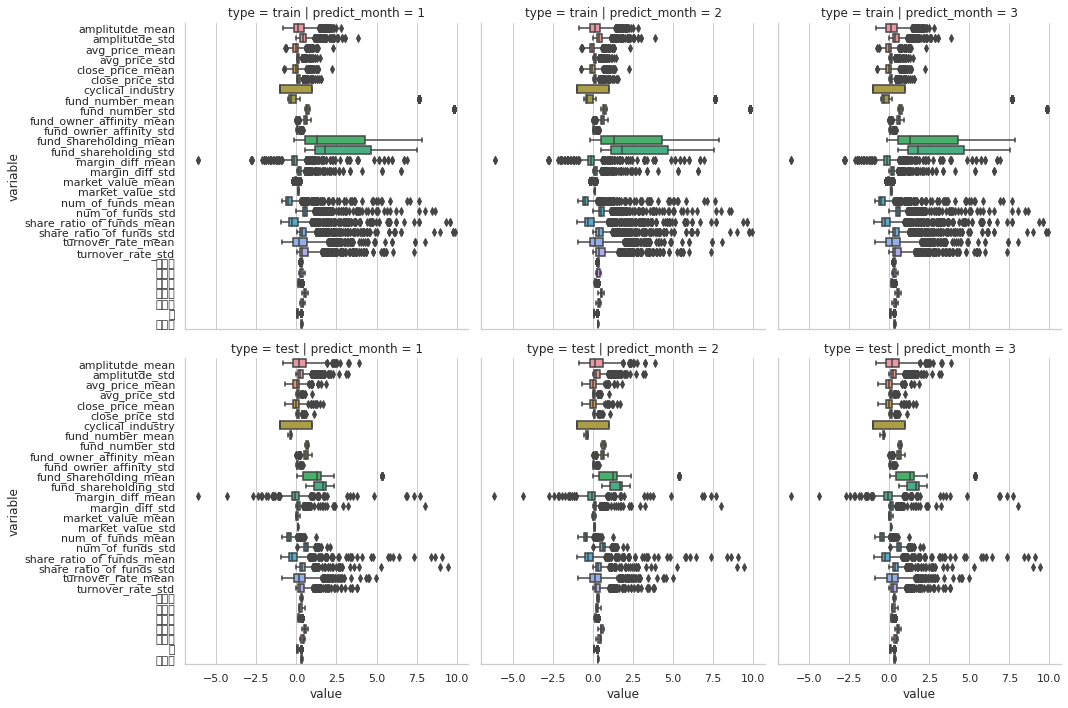

In [10]:
g = sns.catplot(kind    = 'box',
                x       = 'value',
                y       = 'variable',
                col     = 'predict_month',
                row     = 'type',
                data    = pd.concat(melts))
g

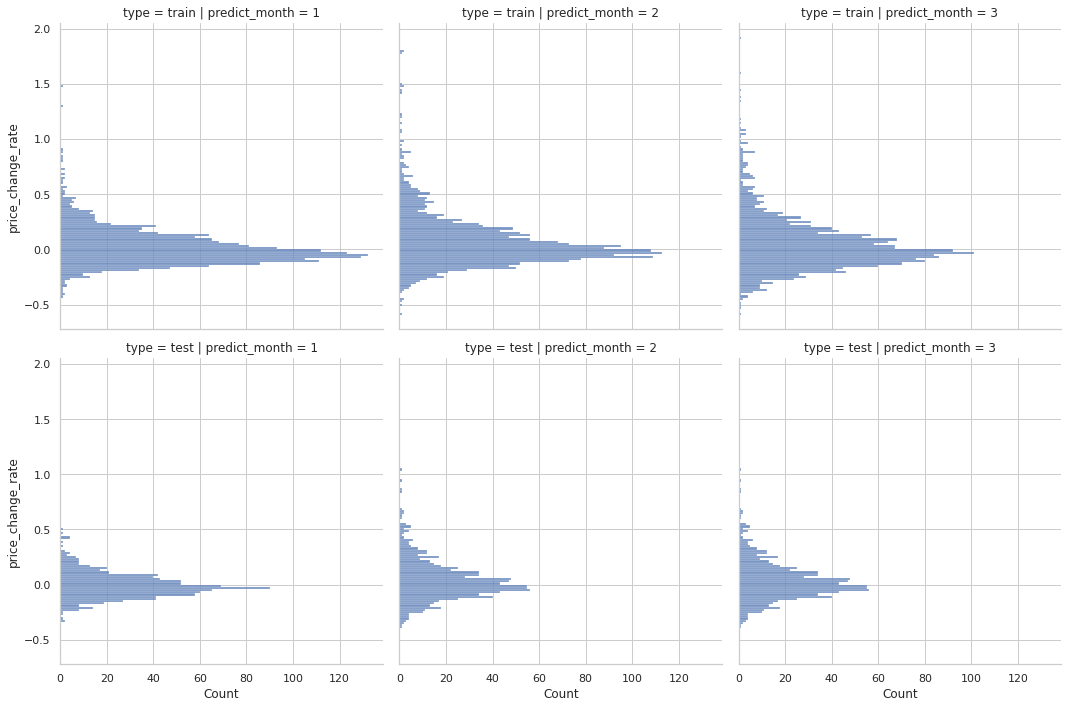

In [11]:
g = sns.displot(pd.concat(labels).reset_index(drop=True),
                y = 'price_change_rate',
                col = 'predict_month',
                row = 'type')
g

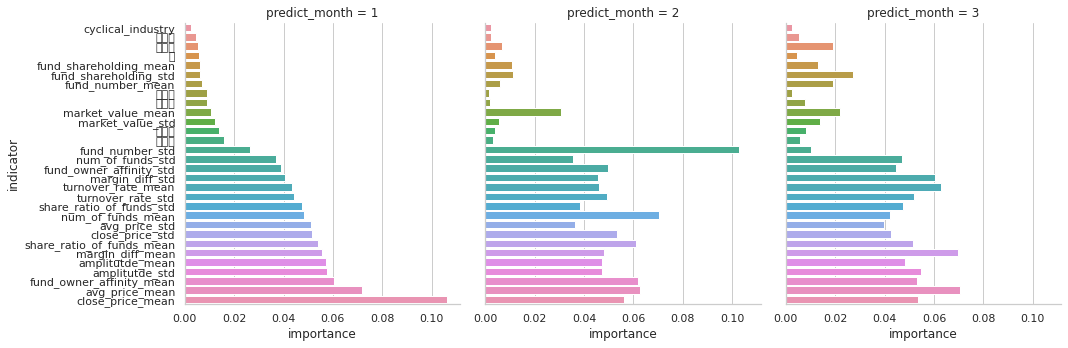

In [12]:
g = sns.catplot(kind    = 'bar',
                x       = 'importance',
                y       = 'indicator',
                col     = 'predict_month',
                data    = pd.concat(importances))
g